In [1]:
import random
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

from logreg import LogRegCCD, generate_dataset

In [2]:
random.seed(42)

In [ ]:
def run_tests(values: list, label: str, n_repeats = 5,
              n: Optional[int] = None, p: Optional[float] = None, g: Optional[float] = None, d: Optional[float] = None,
              save: bool = False):
    
    N = len(values)

    # exactly one value should be None
    assert sum([k is None for k in [n,p,g,d]]) == 1

    lr_rocs = []
    lr_bas = []
    ccd_rocs = []
    ccd_bas = []

    lr_rocs_std = []
    lr_bas_std = []
    ccd_rocs_std = []
    ccd_bas_std = []

    n_i = n
    p_i = p
    g_i = g
    d_i = d

    for i, value in enumerate(values):
        print(f"{i+1}/{N}: {label} = {value}")

        lr_roc_vals = []
        lr_ba_vals = []
        ccd_roc_vals = []
        ccd_ba_vals = []

        if n is None:
            n_i = value
            print("Detected n as param")

        if p is None:
            p_i = value
            print("Detected p as param")

        if g is None:
            g_i = value
            print("Detected g as param")

        if d is None:
            d_i = value
            print("Detected d as param")

        print(f"n: {n_i}, p: {p_i}, g: {g_i}, d: {d_i}")

        for _ in range(n_repeats):
            try:
                X, y = generate_dataset(n=n_i, p=p_i, g=g_i, d=d_i)  # type: ignore
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

                lr = LogisticRegression(penalty=None, random_state=23)
                lgccd = LogRegCCD(lambda_min=1e-3)
                _, best_lambda = lgccd.optimize_lambda(X_train, y_train, X_test, y_test, measure="f1", verbose=1)

                lr.fit(X_train, y_train)
                lr_y_probs = lr.predict_proba(X_test)[:,1]
                lr_preds = (lr_y_probs >= 0.5).astype(int)

                lr_roc_vals.append(roc_auc_score(y_test, lr_y_probs))
                lr_ba_vals.append(balanced_accuracy_score(y_test, lr_preds))

                lgccd.fit(X_train, y_train, best_lambda)
                ccd_roc_vals.append(lgccd.validate(X_test, y_test, measure='roc_auc'))
                ccd_ba_vals.append(lgccd.validate(X_test, y_test, measure='balanced_accuracy'))
            except:
                print(f"X: {X}")
                print(f"y: {y}")
                raise

        lr_rocs.append(np.mean(lr_roc_vals))
        lr_bas.append(np.mean(lr_ba_vals))
        ccd_rocs.append(np.mean(ccd_roc_vals))
        ccd_bas.append(np.mean(ccd_ba_vals))

        lr_rocs_std.append(np.std(lr_roc_vals))
        lr_bas_std.append(np.std(lr_ba_vals))
        ccd_rocs_std.append(np.std(ccd_roc_vals))
        ccd_bas_std.append(np.std(ccd_ba_vals))

    data = {
        label: values,
        'lr_rocs': lr_rocs,
        'lr_rocs_std': lr_rocs_std,
        'lr_bas': lr_bas,
        'lr_bas_std': lr_bas_std,
        'ccd_rocs': ccd_rocs,
        'ccd_rocs_std': ccd_rocs_std,
        'ccd_bas': ccd_bas,
        'ccd_bas_std': ccd_bas_std
    }

    df = pd.DataFrame(data)

    if save:
        df.to_csv(f"results/synthetic/results_{label}.csv")

    return df

def plot_results(data, label, xlabel, metric, log_scale=False, save=False):
    """
    Args:
        data (pd.DataFrame): dataframe with experiments data generated by run_tests() function
        label (str): label of the parameter which is being tested
        xlabel (str): label for x-axis 
        metric (str): which metric to plot, either 'roc' or 'ba'
        log_scale (bool): whether to use log scale
        save (bool): whether to save the figure
    """
    if metric == 'roc':
        plt.errorbar(data[label], data['lr_rocs'], yerr=data['lr_rocs_std'], label="Logistic Regression", fmt='-o', capsize=4)
        plt.errorbar(data[label], data['ccd_rocs'], yerr=data['ccd_rocs_std'], label="LogRegCCD", fmt='-o', capsize=4)
        plt.ylabel("ROC AUC")
    elif metric == 'ba':
        plt.errorbar(data[label], data['lr_bas'], yerr=data['lr_bas_std'], label="Logistic Regression", fmt='-o', capsize=4)
        plt.errorbar(data[label], data['ccd_bas'], yerr=data['ccd_bas_std'], label="LogRegCCD", fmt='-o', capsize=4)
        plt.ylabel("Balanced Accuracy")

    plt.xlabel(xlabel)
    if log_scale:
        plt.xscale("log")
    plt.legend()
    plt.title(f"Models comparison for different values of '{label}'")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    if save:
        plt.savefig(f"results/synthetic/plot_{label}_{metric}.png")

    plt.show()

In [ ]:
## test parameter n

In [18]:
ns = [50, 100, 200, 300, 500, 1000]
df_n = run_tests(values=ns, label="n", p=0.5, g=0.5, d=50, save=True)

1/6: n = 50
Detected n as param
n: 50, p: 0.5, g: 0.5, d: 50


100%|██████████| 100/100 [00:05<00:00, 16.67it/s]


2/6: n = 100
Detected n as param
n: 100, p: 0.5, g: 0.5, d: 50


100%|██████████| 100/100 [00:06<00:00, 15.47it/s]


3/6: n = 200
Detected n as param
n: 200, p: 0.5, g: 0.5, d: 50


100%|██████████| 100/100 [00:07<00:00, 12.66it/s]


4/6: n = 300
Detected n as param
n: 300, p: 0.5, g: 0.5, d: 50


100%|██████████| 100/100 [00:08<00:00, 12.15it/s]


5/6: n = 500
Detected n as param
n: 500, p: 0.5, g: 0.5, d: 50


100%|██████████| 100/100 [00:11<00:00,  9.09it/s]


6/6: n = 1000
Detected n as param
n: 1000, p: 0.5, g: 0.5, d: 50


100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


In [19]:
df_n

,n,lr_rocs,lr_rocs_std,lr_bas,lr_bas_std,ccd_rocs,ccd_rocs_std,ccd_bas,ccd_bas_std
0,50,0.596148,0.183474,0.599405,0.137707,0.748772,0.051849,0.684921,0.071752
1,100,0.588464,0.107036,0.548863,0.107798,0.652425,0.108469,0.592490,0.093105
2,200,0.655326,0.041516,0.612065,0.039791,0.757016,0.050415,0.709508,0.033759
3,300,0.640708,0.075738,0.608439,0.063816,0.760505,0.048420,0.688922,0.071894
4,500,0.724533,0.030624,0.665839,0.017075,0.801063,0.023385,0.714461,0.044448
5,1000,0.733167,0.024143,0.659956,0.021646,0.751893,0.026779,0.692887,0.021107


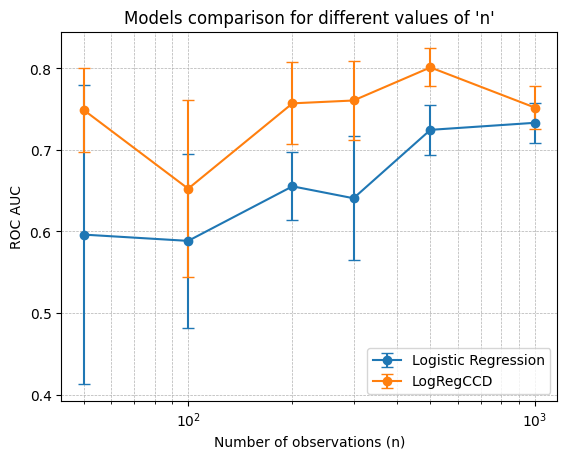

In [20]:
plot_results(df_n, "n", "Number of observations (n)", metric="roc", log_scale=True, save=True)

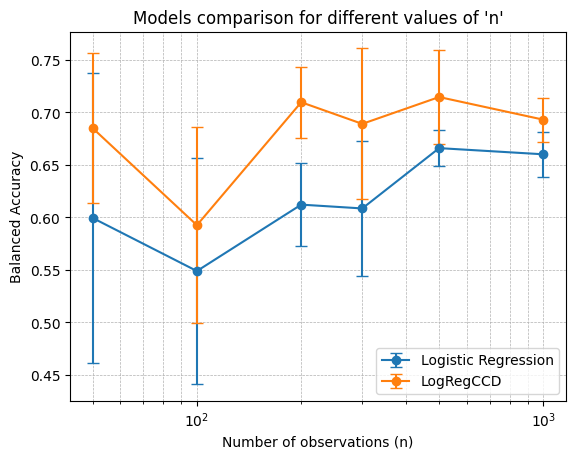

In [21]:
plot_results(df_n, "n", "Number of observations (n)", metric="ba", log_scale=True, save=True)

In [ ]:
## parameter d

In [22]:
ds = [5, 10, 20, 50, 100, 250]
df_d = run_tests(values=ds, label="d", p=0.5, g=0.5, n=500, save=True)

1/6: d = 5
Detected d as param
n: 500, p: 0.5, g: 0.5, d: 5


100%|██████████| 100/100 [00:00<00:00, 107.97it/s]


2/6: d = 10
Detected d as param
n: 500, p: 0.5, g: 0.5, d: 10


100%|██████████| 100/100 [00:01<00:00, 56.77it/s]


3/6: d = 20
Detected d as param
n: 500, p: 0.5, g: 0.5, d: 20


100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


4/6: d = 50
Detected d as param
n: 500, p: 0.5, g: 0.5, d: 50


100%|██████████| 100/100 [00:11<00:00,  8.95it/s]


5/6: d = 100
Detected d as param
n: 500, p: 0.5, g: 0.5, d: 100


100%|██████████| 100/100 [00:24<00:00,  4.07it/s]


6/6: d = 250
Detected d as param
n: 500, p: 0.5, g: 0.5, d: 250


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


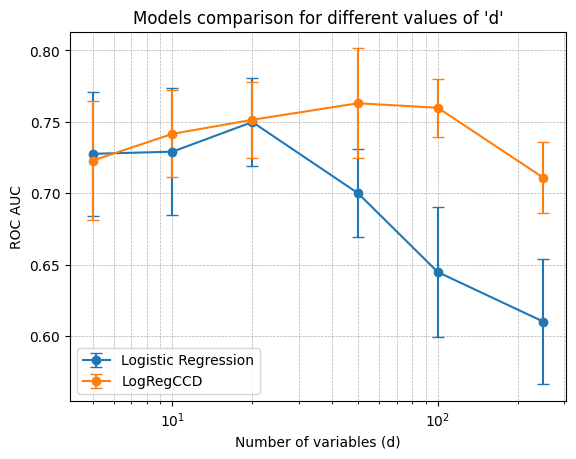

In [23]:
plot_results(df_d, "d", "Number of variables (d)", metric="roc", log_scale=True, save=True)

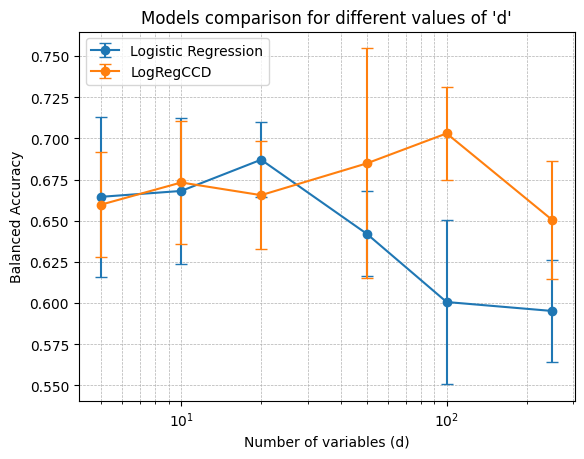

In [24]:
plot_results(df_d, "d", "Number of variables (d)", metric="ba", log_scale=True, save=True)

In [ ]:
## parameter p

In [25]:
ps = [0.1, 0.2, 0.35, 0.5, 0.65, 0.8, 0.9]
df_p = run_tests(values=ps, label="p", d=50, g=0.5, n=500, save=True)

1/7: p = 0.1
Detected p as param
n: 500, p: 0.1, g: 0.5, d: 50


100%|██████████| 100/100 [00:09<00:00, 10.57it/s]


2/7: p = 0.2
Detected p as param
n: 500, p: 0.2, g: 0.5, d: 50


100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


3/7: p = 0.35
Detected p as param
n: 500, p: 0.35, g: 0.5, d: 50


100%|██████████| 100/100 [00:09<00:00, 10.41it/s]


4/7: p = 0.5
Detected p as param
n: 500, p: 0.5, g: 0.5, d: 50


100%|██████████| 100/100 [00:10<00:00,  9.81it/s]


5/7: p = 0.65
Detected p as param
n: 500, p: 0.65, g: 0.5, d: 50


100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


6/7: p = 0.8
Detected p as param
n: 500, p: 0.8, g: 0.5, d: 50


100%|██████████| 100/100 [00:10<00:00,  9.57it/s]


7/7: p = 0.9
Detected p as param
n: 500, p: 0.9, g: 0.5, d: 50


100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


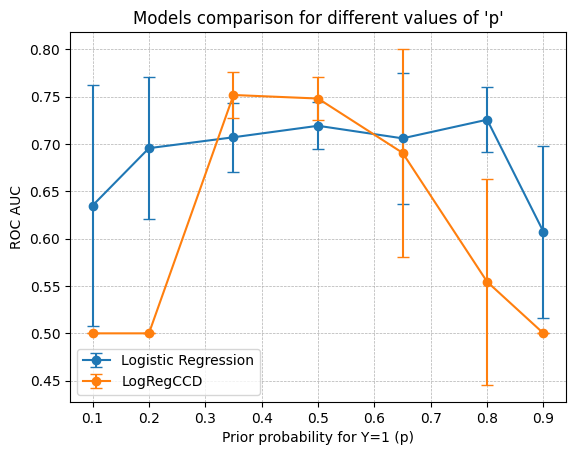

In [34]:
plot_results(df_p, "p", "Prior probability for Y=1 (p)", metric="roc", save=True)

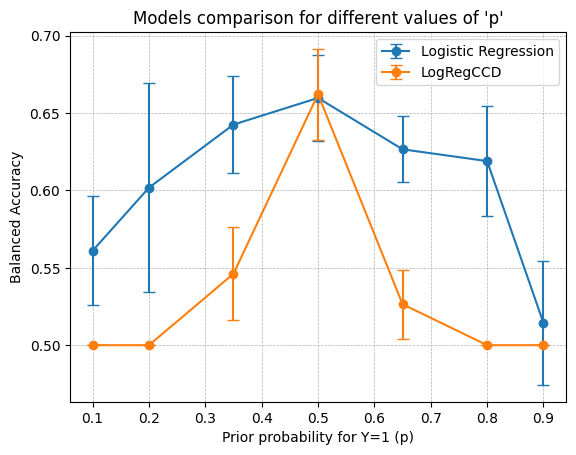

In [33]:
plot_results(df_p, "p", "Prior probability for Y=1 (p)", metric="ba", save=True)

In [ ]:
## parameter g

In [28]:
gs = [0.1, 0.3, 0.5, 0.7, 0.9]
df_g = run_tests(values=gs, label="g", d=50, p=0.5, n=500, save=True)

1/5: g = 0.1
Detected g as param
n: 500, p: 0.5, g: 0.1, d: 50


100%|██████████| 100/100 [00:10<00:00,  9.72it/s]


2/5: g = 0.3
Detected g as param
n: 500, p: 0.5, g: 0.3, d: 50


100%|██████████| 100/100 [00:09<00:00, 10.60it/s]


3/5: g = 0.5
Detected g as param
n: 500, p: 0.5, g: 0.5, d: 50


100%|██████████| 100/100 [00:10<00:00,  9.85it/s]


4/5: g = 0.7
Detected g as param
n: 500, p: 0.5, g: 0.7, d: 50


100%|██████████| 100/100 [00:09<00:00, 10.64it/s]


5/5: g = 0.9
Detected g as param
n: 500, p: 0.5, g: 0.9, d: 50


100%|██████████| 100/100 [00:10<00:00,  9.78it/s]


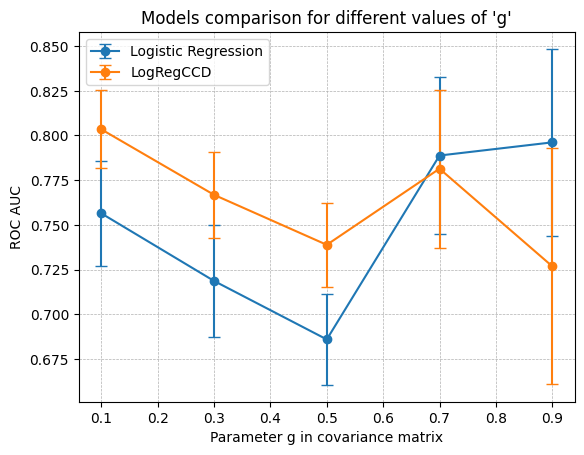

In [32]:
plot_results(df_g, "g", "Parameter g in covariance matrix", metric="roc", save=True)

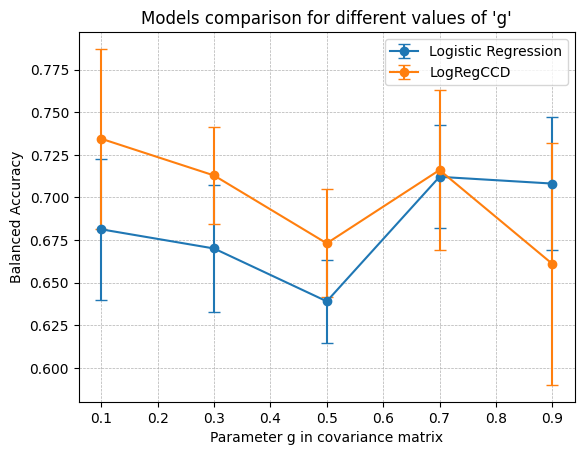

In [31]:
plot_results(df_g, "g", "Parameter g in covariance matrix", metric="ba", save=True)

In [ ]:
## big number of variables

In [ ]:
p = 0.5
g = 0.5
ns = [100, 250, 500, 1000]
ds = [int(nn / 2) for nn in ns]
N = len(ns)

n_repeats = 5

lr_rocs = []
lr_bas = []
ccd_rocs = []
ccd_bas = []

for i, (n,d) in enumerate(zip(ns,ds)):
    print(f"{i+1}/{N}: n = {n}")

    lr_roc_vals = []
    lr_ba_vals = []
    ccd_roc_vals = []
    ccd_ba_vals = []

    for _ in range(n_repeats):
        X, y = generate_dataset(n=n, p=p, g=g, d=d)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

        lr = LogisticRegression(penalty=None, random_state=23)
        lgccd = LogRegCCD(lambda_min=1e-3)
        _, best_lambda = lgccd.optimize_lambda(X_train, y_train, X_test, y_test, measure="roc_auc", verbose=1)
        print(best_lambda)

        lr.fit(X_train, y_train)
        lr_y_probs = lr.predict_proba(X_test)[:,1]
        lr_preds = (lr_y_probs >= 0.5).astype(int)

        lr_roc_vals.append(roc_auc_score(y_test, lr_y_probs))
        lr_ba_vals.append(balanced_accuracy_score(y_test, lr_preds))

        lgccd.fit(X_train, y_train, best_lambda)
        ccd_roc_vals.append(lgccd.validate(X_test, y_test, measure='roc_auc'))
        ccd_ba_vals.append(lgccd.validate(X_test, y_test, measure='balanced_accuracy'))

    lr_rocs.append(np.mean(lr_roc_vals))
    lr_bas.append(np.mean(lr_ba_vals))
    ccd_rocs.append(np.mean(ccd_roc_vals))
    ccd_bas.append(np.mean(ccd_ba_vals))

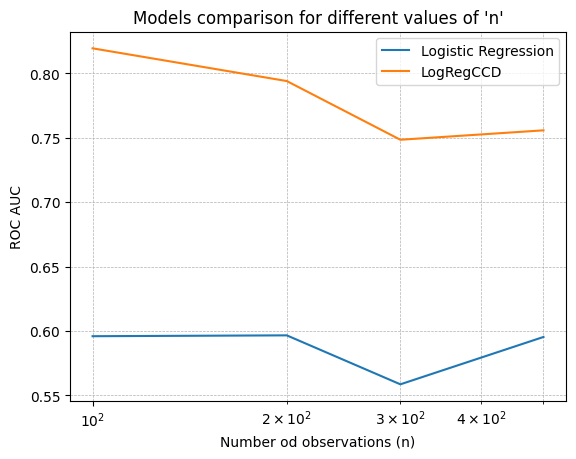

In [56]:
plt.plot(ns[:4], lr_rocs, label="Logistic Regression")
plt.plot(ns[:4], ccd_rocs, label="LogRegCCD")
plt.xlabel("Number od observations (n)")
plt.ylabel("ROC AUC")
plt.xscale("log")
plt.legend()
plt.title("Models comparison for different values of 'n'")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

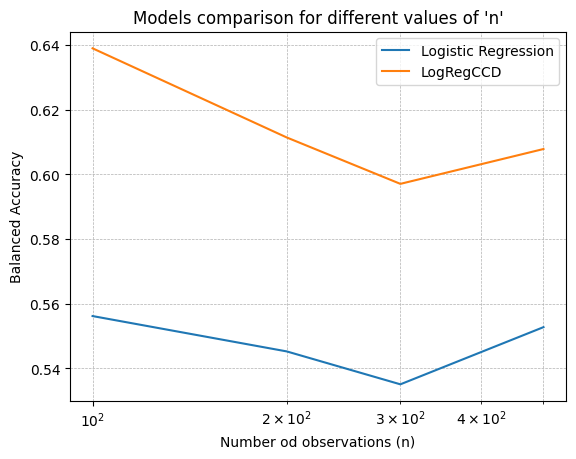

In [57]:
plt.plot(ns[:4], lr_bas, label="Logistic Regression")
plt.plot(ns[:4], ccd_bas, label="LogRegCCD")
plt.xlabel("Number od observations (n)")
plt.ylabel("Balanced Accuracy")
plt.xscale("log")
plt.legend()
plt.title("Models comparison for different values of 'n'")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()